In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tools
from scipy.constants import c, nu2lambda

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png{
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(8,4)

In [5]:
'''sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')'''
sys.path.append('C:\\Program Files\\Lumerical\\v242\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v242\\api\\python\\lumapi.py')

In [6]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi
fdtdApi = lumapi.FDTD()

In [7]:
fdtdApi.switchtolayout()
fdtdApi.deleteall()

In [8]:
#units
nm = 1e-9
um = 1e-6

In [9]:
# Parametros do acoplador direcional
L_t = 1*um
L_1 = 12.4*um
L_2 = 4.6*um
lc = 2*L_1 + L_2 + 2*L_t 
gap = 200*nm
rad = 5*um
# Parametros do guia de onda
wg_width = 500*nm
wg_height = 220*nm
# Materiais do guia de onda
material_Clad = 'SiO2 (Glass) - Palik'
material_core = 'Si (Silicon) - Palik'

In [10]:
#Banda de operação (banda C)
wl_start = 1530*nm
wl_stop = 1565*nm
nbmFrqPnts = 21
# Nome do arquivo
filename = 'dc_FDTd_%d_nm_%03d_um'%(gap/nm,lc/um) 

In [11]:
## Configuração do FDTD
# Tempo de simulação
simulation_time = (np.pi*rad+lc)*7/c+200e-15

# Dimensões da porta
portSize = 2*um
portBcDist = 6*um
# Dimensões do volume do solver
x_FDTD = lc/2 + 2*rad
y_FDTD = -rad-gap/2-wg_height
x_span_FDTD = 1.1*lc+2*rad+portBcDist
y_span_FDTD = 2*rad + gap + 2*wg_width+portSize
z_span_FDTD = 5*um
# Material
backGroundMaterial = material_Clad
# Precisão do mesh
mesh_accuracy = 3
# condições de fronteira
z_min_bc = 'Symmetric'

In [12]:
# Parametrosa das portas
y_port_off = 0.5*um
x_port = np.array([lc+3*rad, rad, lc+3*rad, rad])
y_port = np.array([-(2*rad+gap+wg_width+y_port_off),-(2*rad+gap+wg_width+y_port_off),0+y_port_off,0+y_port_off])
x_span_port = 4*um
z_span_port = 4*um
mode_selection = 'fundamental TE mode'
injection_axis = 'y-axis'

## Criando dispositivo

In [13]:
gap = 200 * nm
gap2 = 300 * nm
x_span_core = 500 * nm
x_span_core_top = 600 * nm
x_span_core_bottom = 400 * nm
x_core = gap2 / 2
y_core = 0.0 * um
y_span_core = 0.220 * um
z_core = 0.0 * um
z_core_span = wg_height
def buildDevice(L_1,L_2,L_t,lc):
    ###########
    gap = 200 * nm
    gap2 = 300 * nm
    x_span_core = 500 * nm
    x_span_core_top = 600 * nm
    x_span_core_bottom = 400 * nm
    x_core = gap2 / 2
    y_core = 0.0 * um
    y_span_core = 0.220 * um
    z_core = 0.0 * um
    z_core_span = wg_height
    ###########
    
    
    vertices_top = np.array([
        [  L_2/2 + L_t + L_1,       0       ],  
        [  L_2/2 + L_t + L_1,       x_span_core     ],  
        [  L_2/2 + L_t,             x_span_core     ],  
        [  L_2/2,                   x_span_core_top ],  
        [ -L_2/2,                   x_span_core_top ],  
        [ -L_2/2 - L_t,             x_span_core     ],  
        [ -L_2/2 - L_t - L_1,       x_span_core     ],  
        [ -L_2/2 - L_t - L_1,       0       ], 
    ], dtype=float)
    
    vertices_bottom = np.array([
        (L_2 / 2 + L_t + L_1, -gap - x_span_core),
        (L_2 / 2 + L_t + L_1, -gap),
        (L_2 / 2 + L_t, -gap),
        (L_2 / 2, -gap2),
        (-L_2 / 2, -gap2),
        (-L_2 / 2 - L_t, -gap),
        (-L_2 / 2 - L_t - L_1, -gap),
        (-L_2 / 2 - L_t - L_1, -gap - x_span_core),
    ])
    
    fdtdApi.addpoly()
    fdtdApi.set('name',     'wg_top')
    fdtdApi.set('vertices', vertices_top)
    fdtdApi.set('z span',   z_core_span)
    fdtdApi.set('z',        0)
    fdtdApi.set('material', material_core)
    
    fdtdApi.addpoly()
    fdtdApi.set('name',     'wg_bottom')
    fdtdApi.set('vertices', vertices_bottom)
    fdtdApi.set('z span',   z_core_span)
    fdtdApi.set('z',        0)
    fdtdApi.set('material', material_core)
    
    x_wg_top = fdtdApi.getnamed('wg_top','x')
    y_wg_top = fdtdApi.getnamed('wg_top','y')
    x_wg_bottom = fdtdApi.getnamed('wg_top','x')
    y_wg_bottom = fdtdApi.getnamed('wg_top','y')
    
    for i in range(4):
        fdtdApi.addobject('90_bend_wg')
        fdtdApi.set('name',f'arco{i}')
        fdtdApi.set('material',material_core)
        fdtdApi.set('base width',wg_width)
        fdtdApi.set('base height',wg_height)
        fdtdApi.set('start angle', i*90)
        fdtdApi.set('radius',rad)
        fdtdApi.set('z',0)
        
    fdtdApi.setnamed('arco0','x',x_wg_bottom+lc/2)
    fdtdApi.setnamed('arco1','x',x_wg_bottom-lc/2)
    fdtdApi.setnamed('arco2','x',x_wg_top-lc/2)
    fdtdApi.setnamed('arco3','x',x_wg_top+lc/2)
    
    fdtdApi.setnamed('arco0','y',y_wg_bottom-rad-wg_width/2-gap)
    fdtdApi.setnamed('arco1','y',y_wg_bottom-rad-wg_width/2-gap)
    fdtdApi.setnamed('arco2','y',y_wg_top+rad+wg_width/2)
    fdtdApi.setnamed('arco3','y',y_wg_top+rad+wg_width/2)
    
    for i in range(4):
        fdtdApi.addrect()
        fdtdApi.set('name',f'port{i}')
        fdtdApi.set('material',material_core)
        fdtdApi.set('x span',wg_width)
        fdtdApi.set('y span',portSize)
        fdtdApi.set('z span',wg_height)
        fdtdApi.set('z',0)
    
    fdtdApi.setnamed('port0', 'y', (y_wg_bottom - rad - portSize / 2 - gap - wg_width / 2))
    fdtdApi.setnamed('port0', 'x', x_wg_top + lc / 2 + rad)
    
    fdtdApi.setnamed('port1', 'y', (y_wg_bottom - rad - portSize / 2 - gap - wg_width / 2))
    fdtdApi.setnamed('port1', 'x', x_wg_top - lc / 2 - rad)
    
    fdtdApi.setnamed('port2', 'y', (y_wg_top + rad + portSize / 2 + wg_width / 2))
    fdtdApi.setnamed('port2', 'x', x_wg_top + lc / 2 + rad)
    
    fdtdApi.setnamed('port3', 'y', (y_wg_top + rad + portSize / 2 + wg_width / 2))
    fdtdApi.setnamed('port3', 'x', x_wg_top - lc / 2 - rad)
    
    return _

## Adição do solver FDTD, porta e monitor

In [14]:
# solver
def SolverPorts():
    x_wg_top = fdtdApi.getnamed('wg_top','x')
    y_wg_top = fdtdApi.getnamed('wg_top','y')
    x_wg_bottom = fdtdApi.getnamed('wg_top','x')
    y_wg_bottom = fdtdApi.getnamed('wg_top','y')
    fdtdApi.addfdtd()
    fdtdApi.set('x', x_wg_top)
    fdtdApi.set('x span', x_span_FDTD)
    fdtdApi.set('y', y_wg_top)
    fdtdApi.set('y span', y_span_FDTD)
    fdtdApi.set('z', 0)
    fdtdApi.set('z span', z_span_FDTD)
    fdtdApi.set('background material', backGroundMaterial)
    fdtdApi.set('mesh accuracy', mesh_accuracy)
    fdtdApi.set('simulation time', simulation_time)
    fdtdApi.set('z min bc', z_min_bc)
    x_port = []
    y_port = []
    for i in range(4):
        x_port.append(fdtdApi.getnamed(f'port{i}','x'))
        y_port.append(fdtdApi.getnamed(f'port{i}','y'))
    
    # portas
    for i in range(4):
        fdtdApi.addport()
        fdtdApi.set('name',f'port {i+1}')
        fdtdApi.set('x',x_port[i])
        fdtdApi.set('x span',x_span_port)
        fdtdApi.set('y',y_port[i])
        fdtdApi.set('z',0)
        fdtdApi.set('z span',z_span_port)
        fdtdApi.set('mode selection',mode_selection)
        fdtdApi.set('injection axis',injection_axis)
    for i in range(4):
        fdtdApi.select(f'FDTD::ports::port {i+1}')
        fdtdApi.set('x span', 4*1e-6)
    fdtdApi.setnamed('FDTD::ports::port 3','direction','Backward')
    fdtdApi.setnamed('FDTD::ports::port 4','direction','Backward')
    
    # configuração da banda de simulação
    fdtdApi.setnamed('FDTD','global source wavelength start',wl_start)
    fdtdApi.setnamed('FDTD','global source wavelength stop',wl_stop)
    fdtdApi.setnamed('FDTD::ports','monitor frequency points',nbmFrqPnts)
    
    return _

In [15]:
fdtdApi.switchtolayout()
L_t = 1 * um
L_1 = 12.4 * um
L_2 = 4.6 * um
lc = 2 * L_1 + L_2 + 2 * L_t

fdtdApi.deleteall()
buildDevice(L_1, L_2, L_t, lc)
SolverPorts()

In [16]:
# monitor de campo - lembrar de desativar para otimização
x_wg_top = fdtdApi.getnamed('wg_top','x')
y_wg_top = fdtdApi.getnamed('wg_top','y')
x_wg_bottom = fdtdApi.getnamed('wg_top','x')
y_wg_bottom = fdtdApi.getnamed('wg_top','y')
fdtdApi.addprofile()
fdtdApi.set('override global monitor settings', True)
fdtdApi.set('frequency points', nbmFrqPnts)
fdtdApi.set('x', x_wg_top)
fdtdApi.set('x span', x_span_FDTD)
fdtdApi.set('y', y_wg_top)
fdtdApi.set('y span', y_span_FDTD)
fdtdApi.set('z', 0)

In [17]:
# salvando arquivo
filename ='dc_FDTD_%d_nm_%03d_um'%(gap*nm,lc*1e7)
fdtdApi.save(filename)

In [21]:
fdtdApi.select('FDTD')
fdtdApi.set('express mode',1)

In [22]:
#simulação
fdtdApi.run()

In [23]:
# importando campo elétrico
eField = np.abs(np.squeeze(fdtdApi.getelectric('monitor')))**2

In [24]:
# apresentação do campo eletrico obtido
indxLamda = 10
x_efielf = fdtdApi.getdata('monitor','x')
y_efielf = fdtdApi.getdata('monitor','y')
freq = fdtdApi.getdata('monitor','f')
lmbd = c/freq
xmin = um*np.min(x_efielf)
xmax = um*np.max(x_efielf)
ymin = um*np.min(y_efielf)
ymax = um*np.max(y_efielf)

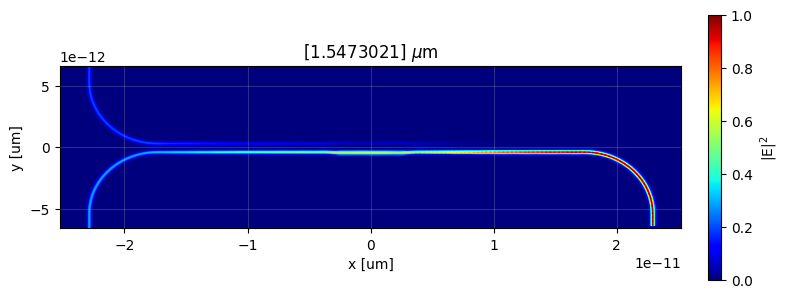

In [25]:
# Escala linear
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111)

im1 = ax1.imshow(np.rot90(eField[:,:,indxLamda]),cmap= 'jet', extent=[xmin,xmax,ymin,ymax], vmin=0,vmax=1)

colorbar = plt.colorbar(im1, fraction=0.02, pad=0.04)
colorbar.set_label(r'|E|$^2$')
ax1.set_xlabel('x [um]')
ax1.set_ylabel('y [um]')
ax1.set_title(rf'{lmbd[indxLamda]/um} $\mu$m')
ax1.grid(which='major', alpha=0.25)
plt.savefig(f'efield {filename} linear.png', bbox_inches='tight', dpi=300)
plt.tight_layout()


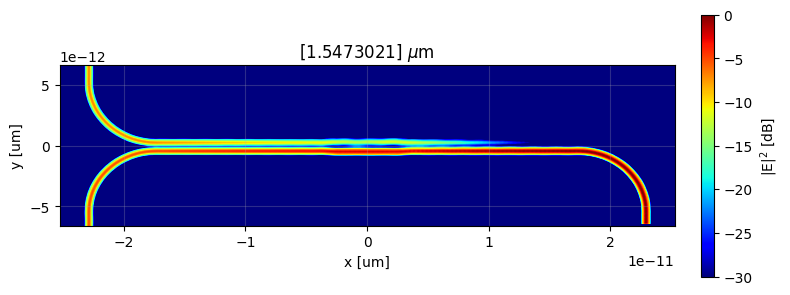

In [26]:
# Escala logarítmica
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111)
im2 = ax2.imshow(10*np.log10(np.rot90(eField[:,:,indxLamda])),cmap= 'jet', extent=[xmin,xmax,ymin,ymax], vmin=-30,vmax=0)

colorbar = plt.colorbar(im2, fraction=0.02, pad=0.04)
colorbar.set_label(r'|E|$^2$ [dB]')

ax2.set_xlabel('x [um]')
ax2.set_ylabel('y [um]')
ax2.set_title(rf'{lmbd[indxLamda]/um} $\mu$m')
ax2.grid(which='major', alpha=0.25)

plt.tight_layout()
plt.savefig(f'efield {filename} log.png', bbox_inches='tight', dpi=300)

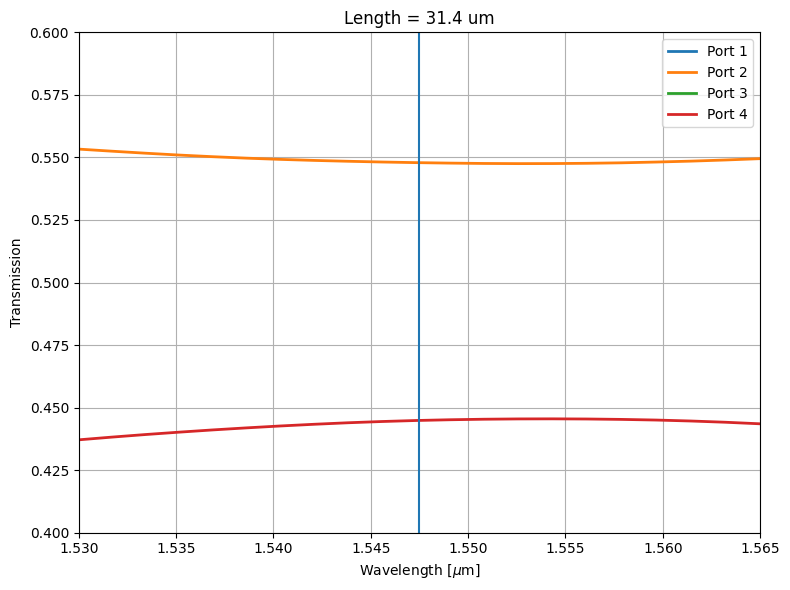

In [27]:
# Apresenta a transmissão do dispositivo em cada porta.
fig3 = plt.figure(figsize=(8,6))
for i in range(4):
    ports = fdtdApi.getresult("FDTD::ports::port %d" %(i+1), "T")
    plt.plot(1e6*ports['lambda'], np.abs(ports["T"]), label = "Port %d" %(i+1), linewidth = 2)

#plt.plot([lmbd[indxLamda]/um, lmbd[indxLamda]/um], [0,1.1], 'k--')
plt.vlines(1.5475,0,1)
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("Transmission")
plt.xlim([wl_start/um, wl_stop/um])
plt.ylim([0.4,0.6])
plt.title(rf"Length = %.1f um" %(lc/um))
plt.grid(True)

plt.gca().set_xticks(np.arange(1.53, 1.565, 0.01), minor=True)
plt.gca().grid(which="minor", alpha=0.25)

plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('efield_' + filename + '_transmission.png', bbox_inches='tight')
plt.show()


## Variando o comprimento de acoplamento

In [28]:
import scipy

In [29]:
fdtdApi.switchtolayout()
#fdtdApi.setnamed('monitor','enabled',0)

lct_start = 0*um
lct_stop = 4*um
lct_points = 5
lct = np.linspace(lct_start, lct_stop, lct_points)
lct/um

array([0., 1., 2., 3., 4.])

In [30]:
ports = np.zeros([lct_points,4,nbmFrqPnts])

for i in range(len(lct)):
    lc_wav = lct[i]
    fdtdApi.switchtolayout()
    
    simulation_time = (np.pi*rad+lc_wav)*7/c+200e-15
    fdtdApi.setnamed('FDTD','simulation time',simulation_time)
    
    fdtdApi.deleteall()
    lc = 2 * lc_wav + L_2 + 2 * L_t
    buildDevice(lc_wav, L_2, L_t, lc)
    SolverPorts()
    #fdtdApi.select('FDTD')
    #fdtdApi.set('mesh accuracy', 1)
    filename = f'DC_FDTD_cBand_{gap/nm}_nm_{lc_wav/um}_um'
    fdtdApi.save(filename)
    fdtdApi.run(3)
    
    for j in range(4):
        ports[i,j,:] = fdtdApi.getresult(f"FDTD::ports::port {j+1}", "T")["T"]

LumApiError: 'in run: integer argument to control single or multiple processor mode is deprecated. Use addresource, getresource and setresource instead.'

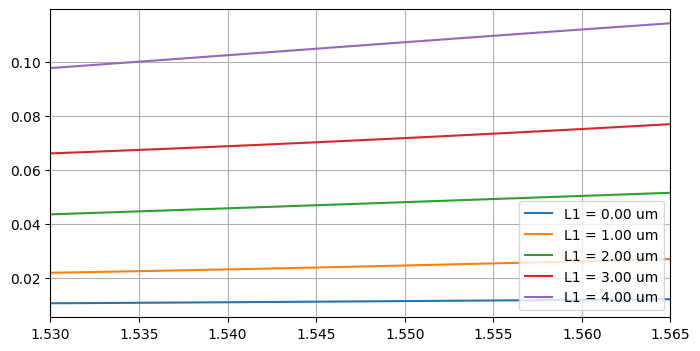

In [87]:
wvl = fdtdApi.getresult('FDTD::ports::port 1', 'T')['lambda']
T = fdtdApi.getresult('FDTD::ports::port 4', 'T')
for i in range(lct_points):
    plt.plot(wvl/um,ports[i,3,:],label=f'L1 = {lct[i]/um:.2f} um')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.xlim(wvl[-1]/um, wvl[0]/um)

## segunda parcela dos comprimentos

In [40]:
fdtdApi.switchtolayout()
#fdtdApi.setnamed('monitor','enabled',0)

lct2_start = 4.5*um
lct2_stop = 8*um
lct2_points = 5
lct2 = np.linspace(lct2_start, lct2_stop, lct2_points)
lct2/um

array([4.5  , 5.375, 6.25 , 7.125, 8.   ])

In [37]:
ports2 = np.zeros([lct2_points,4,nbmFrqPnts])

for i in range(len(lct)):
    lc_wav = lct2[i]
    fdtdApi.switchtolayout()
    
    simulation_time = (np.pi*rad+lc_wav)*7/c+200e-15
    fdtdApi.setnamed('FDTD','simulation time',simulation_time)
    
    fdtdApi.deleteall()
    lc = 2 * lc_wav + L_2 + 2 * L_t
    buildDevice(lc_wav, L_2, L_t, lc)
    SolverPorts()
    #fdtdApi.select('FDTD')
    #fdtdApi.set('mesh accuracy', 1)
    filename = f'DC_FDTD_cBand_{gap/nm}_nm_{lc_wav/um}_um'
    fdtdApi.save(filename)
    fdtdApi.run(3)
    
    for j in range(4):
        ports2[i,j,:] = fdtdApi.getresult(f"FDTD::ports::port {j+1}", "T")["T"]

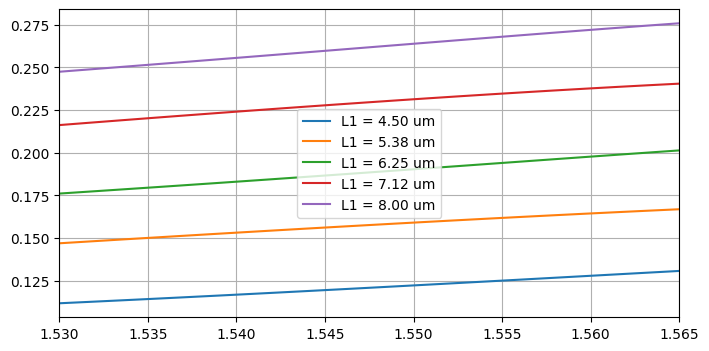

In [38]:
wvl2 = fdtdApi.getresult('FDTD::ports::port 1', 'T')['lambda']
T2 = fdtdApi.getresult('FDTD::ports::port 4', 'T')
for i in range(lct_points):
    plt.plot(wvl/um,ports2[i,3,:],label=f'L1 = {lct2[i]/um:.2f} um')
    plt.legend()
    plt.grid(True)
    plt.xlim(wvl[-1]/um, wvl[0]/um)

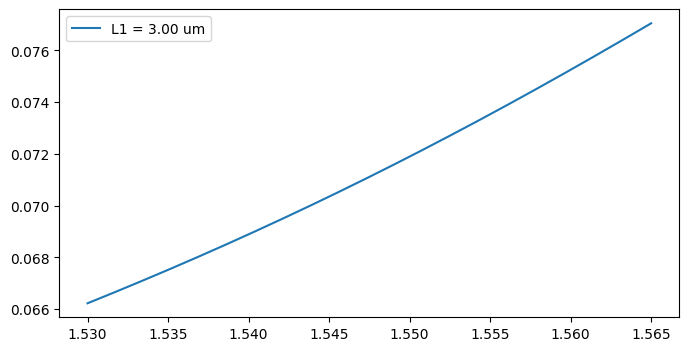

In [65]:
#plt.plot(wvl/um,ports2[4,3,:],label=f'L1 = {lct2[4]/um:.2f} um')
plt.plot(wvl/um,ports[3,3,:],label=f'L1 = {lct[3]/um:.2f} um')
#plt.ylim(0,0.4)
plt.legend()

## Terceira parcela dos comprimentos

In [66]:
fdtdApi.switchtolayout()
#fdtdApi.setnamed('monitor','enabled',0)

lct3_start = 12.5*um
lct3_stop = 15*um
lct3_points = 5
lct3 = np.linspace(lct3_start, lct3_stop, lct3_points)
lct3/um

array([12.5  , 13.125, 13.75 , 14.375, 15.   ])

In [67]:
ports3 = np.zeros([lct3_points,4,nbmFrqPnts])

for i in range(len(lct)):
    lc_wav = lct3[i]
    fdtdApi.switchtolayout()
    
    simulation_time = (np.pi*rad+lc_wav)*7/c+200e-15
    fdtdApi.setnamed('FDTD','simulation time',simulation_time)
    
    fdtdApi.deleteall()
    lc = 2 * lc_wav + L_2 + 2 * L_t
    buildDevice(lc_wav, L_2, L_t, lc)
    SolverPorts()
    #fdtdApi.select('FDTD')
    #fdtdApi.set('mesh accuracy', 1)
    filename = f'DC_FDTD_cBand_{gap/nm}_nm_{lc_wav/um}_um'
    fdtdApi.save(filename)
    fdtdApi.run(3)
    
    for j in range(4):
        ports3[i,j,:] = fdtdApi.getresult(f"FDTD::ports::port {j+1}", "T")["T"]

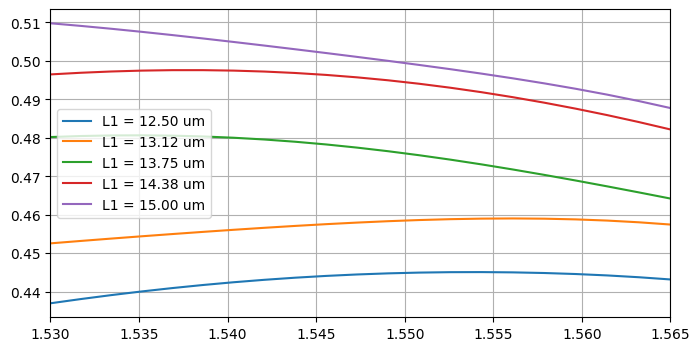

In [68]:
wvl3 = fdtdApi.getresult('FDTD::ports::port 1', 'T')['lambda']
T3 = fdtdApi.getresult('FDTD::ports::port 4', 'T')
for i in range(lct_points):
    plt.plot(wvl/um,ports3[i,3,:],label=f'L1 = {lct3[i]/um:.2f} um')
    plt.legend()
    plt.grid(True)
    plt.xlim(wvl[-1]/um, wvl[0]/um)

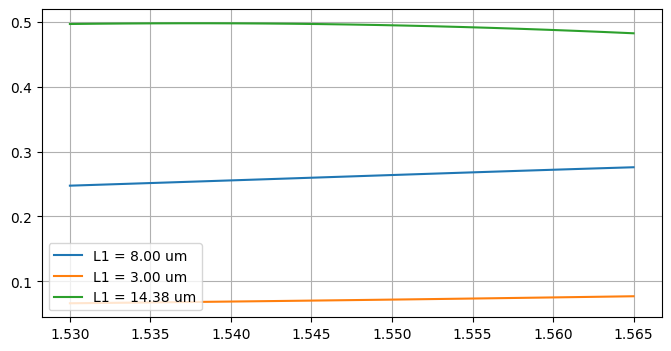

In [84]:
plt.plot(wvl/um,ports2[4,3,:],label=f'L1 = {lct2[4]/um:.2f} um')
plt.plot(wvl/um,ports[3,3,:],label=f'L1 = {lct[3]/um:.2f} um')
plt.plot(wvl/um,ports3[3,3,:],label=f'L1 = {lct3[3]/um:.2f} um')
#plt.ylim(0,0.4)
plt.grid()
plt.legend(loc='lower left')

##  Segunda parcela dos comprimentos parte 2

In [90]:
fdtdApi.switchtolayout()
#fdtdApi.setnamed('monitor','enabled',0)

lct22_start = 3.1*um
lct22_stop = 3.9*um
lct22_points = 5
lct22 = np.linspace(lct22_start, lct22_stop, lct22_points)
lct22/um

array([3.1, 3.3, 3.5, 3.7, 3.9])

In [91]:
ports22 = np.zeros([lct22_points,4,nbmFrqPnts])

for i in range(len(lct)):
    lc_wav = lct22[i]
    fdtdApi.switchtolayout()
    
    simulation_time = (np.pi*rad+lc_wav)*7/c+200e-15
    fdtdApi.setnamed('FDTD','simulation time',simulation_time)
    
    fdtdApi.deleteall()
    lc = 2 * lc_wav + L_2 + 2 * L_t
    buildDevice(lc_wav, L_2, L_t, lc)
    SolverPorts()
    #fdtdApi.select('FDTD')
    #fdtdApi.set('mesh accuracy', 1)
    filename = f'DC_FDTD_cBand_{gap/nm}_nm_{lc_wav/um}_um'
    fdtdApi.save(filename)
    fdtdApi.run(3)
    
    for j in range(4):
        ports22[i,j,:] = fdtdApi.getresult(f"FDTD::ports::port {j+1}", "T")["T"]

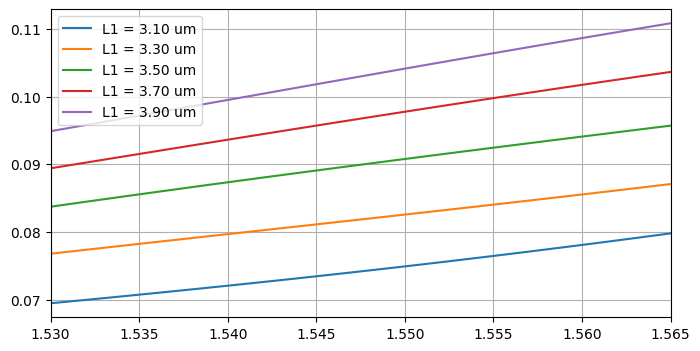

In [94]:
wvl22 = fdtdApi.getresult('FDTD::ports::port 1', 'T')['lambda']
T22 = fdtdApi.getresult('FDTD::ports::port 4', 'T')
for i in range(lct_points):
    plt.plot(wvl/um,ports22[i,3,:],label=f'L1 = {lct22[i]/um:.2f} um')
    plt.legend()
    plt.grid(True)
    plt.xlim(wvl[-1]/um, wvl[0]/um)

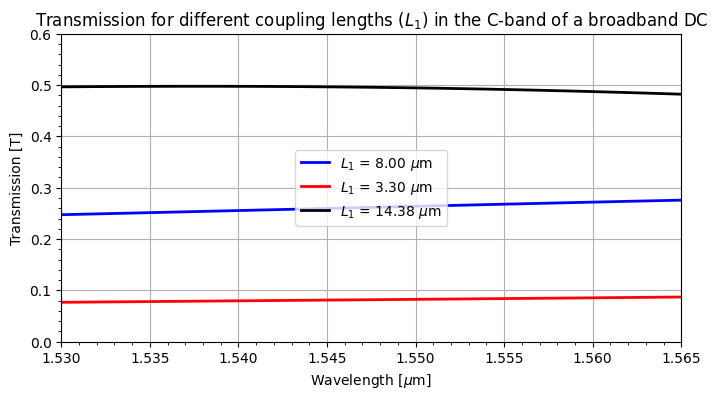

In [126]:
plt.plot(wvl/um,ports2[4,3,:],label=fr'$L_1$ = {lct2[4]/um:.2f} $\mu$m', linewidth=2, color='blue')
plt.plot(wvl/um,ports22[1,3,:],label=fr'$L_1$ = {lct22[1]/um:.2f} $\mu$m', linewidth=2, color='red')
plt.plot(wvl/um,ports3[3,3,:],label=fr'$L_1$ = {lct3[3]/um:.2f} $\mu$m', linewidth=2, color='black')
plt.xlim(1.53,1.565)
plt.ylim(0.0,0.6)
plt.minorticks_on()
plt.title(r'Transmission for different coupling lengths ($L_1$) in the C-band of a broadband DC')
plt.ylabel(r'Transmission [T]')
plt.xlabel(r'Wavelength [$\mu$m]')
plt.grid()
plt.legend(loc='center')
plt.savefig('BB_dc_coupling_length.png', bbox_inches='tight')

## Exportação dos parâmetros S  ($L_1 = 3.30 \mu$m)

In [127]:
fdtdApi.switchtolayout()
L_t = 1 * um
L_1 = 3.3 * um
L_2 = 4.6 * um
lc = 2 * L_1 + L_2 + 2 * L_t

fdtdApi.deleteall()
buildDevice(L_1, L_2, L_t, lc)
SolverPorts()

In [128]:
fdtdApi.run(3)

## Exportação dos parâmetros S  ($L_1 = 14.38 \mu$m)

In [18]:
fdtdApi.switchtolayout()
L_t = 1 * um
L_1 = 14.38 * um
L_2 = 4.6 * um
lc = 2 * L_1 + L_2 + 2 * L_t

fdtdApi.deleteall()
buildDevice(L_1, L_2, L_t, lc)
SolverPorts()

## Exportação dos parâmetros S  ($L_1 = 8 \mu$m)

In [18]:
fdtdApi.switchtolayout()
L_t = 1 * um
L_1 = 8 * um
L_2 = 4.6 * um
lc = 2 * L_1 + L_2 + 2 * L_t

fdtdApi.deleteall()
buildDevice(L_1, L_2, L_t, lc)
SolverPorts()

In [ ]:
fdtdApi.run(3)

## Lumerical script to export gds file

In [ ]:
'''
f = gdsopen('meugds.gds');
cellname = 'contour';

gdsbegincell(f,cellname);
for(i =1:length(contour{1}.polygons)){
    a = contour{1}.polygons{i};
    gdsaddpoly(f,1,a);  
}
gdsendcell(f);
gdsclose(f);
'''